In this experiment, we insert the solution from Entropic Regularisation, $\tilde{u}$ as an initial point. 
Tests are included for two instances.

# Primal Dual to solve Discrete Optimal Transport

<div class="alert alert-block alert-success">
    
This notebook we aim at solving DOT instances using modern optimisation algorithms that outperform the simplex method. To do this we will use the Primal Dual framework. 
    
The notebook is divided in three parts. First, Condat's projection into the ℓ<sub>1</sub> ball algorithm is implemented. Second, the algorithm is used to find feasible solutions of DOT. Finally, the Primal Dual algorithm is tested. The results are automatically stored with an unique identifier and some performance plots are presented.
</div>

* Laurent Condat. <i>Fast projection onto the simplex and the ℓ<sub>1</sub> ball</i>. Math. Program. 158, 575–585 (2016). [https://doi.org/10.1007/s10107-015-0946-6](https://doi.org/10.1007/s10107-015-0946-6). _Also available at_ [https://hal.archives-ouvertes.fr/hal-01056171v2](https://hal.archives-ouvertes.fr/hal-01056171v2).



* V ̃u, B. (2011). <i>A splitting algorithm for dual monotone inclusions involving cocoercive operators </i>. Adv. Comput. Math, pages 667–681. [https://doi.org/10.1007/s10444-011-9254-8](https://doi.org/10.1007/s10444-011-9254-8).

<div class="alert alert-block alert-info">
Packages
</div>

In [1]:
import numpy    as np
import numpy.ma as ma
import pandas   as pd
import time
import os
import matplotlib.pyplot as plt

# Particular functions
from numpy import zeros, zeros_like, allclose, where, ones, inf, absolute, linspace, tile, maximum, minimum
from numpy.random import default_rng as rng
from numba import jit
from scipy.spatial.distance import cdist
from scipy.linalg import norm

# Algorithm

Now, we will run the Primal Dual algorithm addapted for DOT. To test it, we will run it against some of the DOTMark files. We will aim to transport from one given image to another, which are normalised and flattened in ```C```-order. The matrix of costs is based on a uniform grid within $[0,1]^2$ with $M$ points for the source and $N$ points for the target.

## Instance information

In [2]:
folder = 'Microscopy_Sized'
path = 'Exact/' + folder + '/'

In [3]:
files = [f[:-9] for f in os.listdir(path) if f.endswith('.txt')]
print('There are', len(files), 'instances in this location:')
display(files)

There are 4 instances in this location:


['data16_1002-data16_1010_p=S2',
 'data8_1002-data8_1010_p=S2',
 'data32_1002-data32_1010_p=S2',
 'data64_1002-data64_1010_p=S2']

Select one instance:

In [4]:
instance = files[1]
full_path = path + instance

Load data:

In [5]:
m = np.load(full_path + '_m.npy');    M = m.size
n = np.load(full_path + '_n.npy');    N = n.size
c = np.load(full_path + '_Cost.npy')
sol = np.load(full_path + '_Sol.npy')

In [6]:
with open(full_path + '_Time.txt', 'r') as f:
    obj_exact = eval((f.readlines())[0])['Obj']

Load ER solution:

In [7]:
ER_location = folder + '_Results' + '/' + instance + '/'

In [8]:
ER = np.load( ER_location + 'ER-' + '_Sol.npy')

## Run algorithm

<div class="alert alert-block alert-warning">
    
In what follows, we provide tests for the chosen instance running the Primal Dual approach given by Bằng Công Vũ (2011).
    
    
* V ̃u, B. (2011). <i>A splitting algorithm for dual monotone inclusions involving cocoercive operators </i>. Adv. Comput. Math, pages 667–681. [https://doi.org/10.1007/s10444-011-9254-8](https://doi.org/10.1007/s10444-011-9254-8).
</div>

In [16]:
def primal_dual_improved(c,m,n,iters, collect_obj = False, true_obj = None, 
                         true_obj_tol = 1e-4, true_solution = None, save_iter = False, 
                         guess_x = None,
                         guess_s = None, τ = 1e-3 * 1.9, guess_y = None):
    # Algorithm for calculating solution x, in the primal space
    # and y_1, y_2 in the dual space.
    # Also returns the value of the objective function c*x at each
    # iteration.
    
    '''
        Initialise parameters
    '''
    # Initialise τ
    #τ = 1e-3 * 1.9
    
    # Initialise σ
    σ = 1.0/τ - 1e-5
    
    # Initialise ρ
    ρ = 1.9 #- 1e-4 # this helped in 8x8 but not for bigger colour instances
    
    # Fetch lengths of m and n.
    N = n.size
    M = m.size
    
    print('\n*** Primal Dual with M = {}, N = {}, MN = {} ***\n\n'.format(M,N,M*N))
    
    
    '''
        Initialise matrices
    '''
    # Initialise x & y
    if guess_s is not None:
        if guess_x is not None:
            x = ma.masked_array(guess_x, mask = (guess_s <= 1e-50), fill_value = 0.0)
        else:
            x = ma.masked_array(zeros((M,N)), mask = (guess_s <= 1e-50), fill_value = 0.0)
        if guess_y is not None:
            y = guess_y
        else:
            y = zeros((M,N))
    else:
        if guess_x is not None:
            x = ma.masked_array(guess_x,      mask = zeros((M,N)), fill_value = 0.0)
        else:
            x = ma.masked_array(zeros((M,N)), mask = zeros((M,N)), fill_value = 0.0)
        if guess_y is not None:
            y = guess_y
        else:
            y = zeros((M,N))
        
    # Initialise xₖ, yₖ, xₚ
    xₖ, xₚ = ma.zeros((2,M,N),fill_value=0.0)
    xₖ.mask, xₚ.mask = x.mask, x.mask
    yₖ, u = zeros((2,M,N))
    κ_1, κ_2 = zeros(M), zeros(N)
    
    # Mask c, x, and the exact solution
    cₘ = c[~x.mask]
    xₘ = x.compressed()
    if true_solution is not None:
        sₘ = sol[~x.mask]
    
    '''
        Information from true solution (if available)
    '''
    # Store current objective value
    if collect_obj == True:
        obj = [ (cₘ*xₘ).sum() ]
    
    # Norm of true solution
    if true_solution is not None:
        true_obj_crit = 1.0
        if true_obj is None:
            true_obj = (cₘ*sₘ).sum()
        print('Objective from ground truth:', obj_exact,'\n')
        
    '''
        Iterate the Primal Dual scheme
    '''
    
    every_iter = {
        'it':[], 'obj':[], 'dist_obj':[], 'time':[], 'dist_x':[], 'rel_var':[], 'l_1':[],
        'hyperₘ':{'L2': [], 'max': [], 'min':[]}, 'hyperₙ':{'L2': [], 'max': [], 'min':[]}
                 }
    every_critical = {'it':[], 'obj':[], 'tol':[], 'dist_obj':[], 'time':[], 'dist_x':[], 'l_1':[]}
    
    if true_solution is not None:
        print('     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  ')
        print( '{:-^66}'.format('') )
        
    timed = 0.0
    
    for k in range(iters):
        #print(xₘ.size)
        it_time = time.time()
        
        xₖ[~x.mask] = xₘ - τ * (cₘ + y[~x.mask])        # xₖ = x - τ * (c + y)
        maximum(xₖ, 0.0, xₖ, where=~x.mask)             # xₖ = where(xₖ < 0.0, 0.0, xₖ)
        
        u = y/σ + 2.0*xₖ.data - x.data        # u = (y + σ * (2.0 * xₖ - x))/σ
        
        
        κ_1 = u.sum(1) - m
        κ_2 = u.sum(0) - n
        
        β_1 = κ_1.sum() / (M + N)
        β_2 = κ_2.sum() / (M + N)
               
        yₖ = σ*(tile( (κ_1 - β_1)/N, (N,1)).T + tile( (κ_2 - β_2)/M, (M,1)))
        
    
        # Reset x and y for the next iteration
        #x *= 1-ρ;   xₖ *= ρ;     x += xₖ
        x[~x.mask] *= 1-ρ;   xₖ[~x.mask] *= ρ;     x[~x.mask] += xₖ.compressed()
        y *= 1-ρ;   yₖ *= ρ;     y += yₖ
        
        # Measure time up to this point!
        end = time.time()
        timed += end - it_time
        
        # Recover values from mask
        #print(xₘ.size)
        xₘ = x.compressed()
        ℓ_1 = norm(xₘ,1)
        
        # Update objective function
        if collect_obj == True:
            obj.append( (cₘ*xₘ).sum() )
            # Compute relative objective distance
            if true_solution is not None:
                dist_true_sol = abs(obj[-1] - true_obj)/true_obj
        
        # If all iterations are to be stored:
        if save_iter == True:
            frob_d = norm(sₘ-xₘ)/norm(sₘ)                   # Already Frobenius
            r, s   = x.data.sum(1) - m, x.data.sum(0) - n
            
            every_iter['it'].append( k )
            every_iter['obj'].append( (cₘ*xₘ).sum() )
            every_iter['dist_obj'].append( dist_true_sol if true_obj is not None else np.nan )
            every_iter['time'].append( timed )
            every_iter['dist_x'].append( frob_d )
            every_iter['rel_var'].append( norm(xₚ[~x.mask]-xₘ)/norm(x) if not allclose(xₘ,0) else np.nan )
            every_iter['l_1'].append(ℓ_1)
            # Constrained satisfactibility
            every_iter['hyperₘ']['L2'].append( norm(r)/norm(m) )
            every_iter['hyperₘ']['max'].append( abs(r/maximum(m,1e-7)).max() )
            every_iter['hyperₘ']['min'].append( abs(r/maximum(m,1e-7)).min() )
            every_iter['hyperₙ']['L2'].append( norm(s)/norm(n) )
            every_iter['hyperₙ']['max'].append( abs(s/maximum(n,1e-7)).max() )
            every_iter['hyperₙ']['min'].append( abs(s/maximum(n,1e-7)).min() )
            
        # If a true solution is available, we check the tolerance:
        if true_solution is not None: 
            if dist_true_sol < true_obj_crit:
                frob_d = norm(sₘ-xₘ)/norm(sₘ)
                
                every_critical['it'].append( k )
                every_critical['obj'].append( obj[-1] )
                every_critical['tol'].append( true_obj_crit )
                every_critical['dist_obj'].append( dist_true_sol )
                every_critical['time'].append( timed )
                every_critical['dist_x'].append( frob_d )
                every_critical['l_1'].append(ℓ_1)
                
                print('* {0:6.0f} |   {1:.1e} |  {2:1.1e}  | {3:8.2f} s |   {4:4.4f} |  {5:4.4f}'.format(k,
                                                                            true_obj_crit,
                                                                            dist_true_sol,
                                                                            timed,frob_d,ℓ_1))
                
                # If the prescribed tolerance is reached, we finish.
                if dist_true_sol < true_obj_tol:
                    print('Solution found with given tolerance.')
                    break
                
                # Adjust current level of inner tolerance
                true_obj_crit *= 0.1
        
        # Update previous step
        xₚ = x.copy()
                
    if true_solution is not None:
        print( '{:-^66}'.format('') )
        
    print('\nAlgorithm stopped after {0:.4f} seconds and {1} iterations'.format(timed,k))
    
    
    if collect_obj == False and save_iter == True:
        return x, every_iter
    if collect_obj == True and save_iter == True:
        return x, y, obj, every_critical, every_iter
    else:
        return x

### Results of $8\times 8$

Sparsity plots:

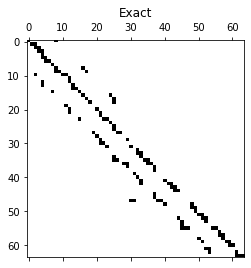

In [16]:
plt.spy(sol); plt.title('Exact'); plt.show()

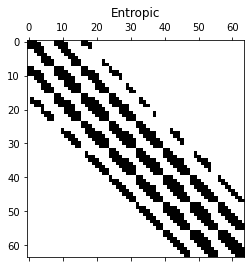

In [17]:
plt.spy(ER); plt.title('Entropic'); plt.show()

**Run without a guess:**

In [17]:
x, y, obj, every_critical, every_iter = primal_dual_improved(c,m,n, 2000, collect_obj = True, true_obj = obj_exact, true_obj_tol = 1e-7, true_solution = sol, save_iter = True, guess_s = None)


*** Primal Dual with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
*      4 |   1.0e+00 |  5.6e-01  |     0.01 s |   0.8888 |  0.9473
*      6 |   1.0e-01 |  5.9e-02  |     0.01 s |   0.8619 |  0.8521
*    327 |   1.0e-02 |  9.8e-03  |     0.08 s |   0.3478 |  0.9996
*    445 |   1.0e-03 |  9.1e-04  |     0.10 s |   0.3268 |  1.0005
*    723 |   1.0e-04 |  6.3e-05  |     0.17 s |   0.3111 |  0.9999
*    724 |   1.0e-05 |  4.7e-06  |     0.17 s |   0.3111 |  0.9999
*   1203 |   1.0e-06 |  6.7e-07  |     0.28 s |   0.3110 |  1.0000
*   1241 |   1.0e-07 |  2.6e-08  |     0.29 s |   0.3110 |  1.0001
Solution found with given tolerance.
------------------------------------------------------------------

Algorithm stopped after 0.2862 seconds and 1241 iterations


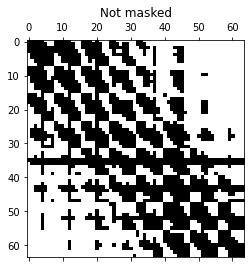

In [28]:
plt.spy(x.data); plt.title('Not masked'); plt.show()

In [167]:
# Support measures
x.mask = (x.data<=0)
Masking_sol, Masking_Truth = ones((2,N,N));    Masking_sol[x.mask] = 0;    Masking_Truth[sol<=0] = 0
Masking_sol[Masking_Truth + Masking_sol != 2] = 0        # Cancel common support
print( 'Shared support:   {0:3.0f} \nApproximation:    {1:3.0f} \nExact support:    {2:3.0f} '.format(
    Masking_sol.sum(),x.compressed().size,sol[sol>0].size) )

Shared support:   127 
Approximation:    1250 
Exact support:    127 


**Include initial mask from ER:**

In [21]:
x, y, obj, every_critical, every_iter = primal_dual_improved(c,m,n, 10000, collect_obj = True, true_obj = obj_exact, true_obj_tol = 1e-7, true_solution = sol, save_iter = True, guess_s = ER)


*** Primal Dual with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
*      1 |   1.0e+00 |  5.8e-01  |     0.00 s |   0.8799 |  0.2558
*      9 |   1.0e-01 |  4.0e-02  |     0.01 s |   0.5692 |  1.0693
*     24 |   1.0e-02 |  9.1e-03  |     0.01 s |   0.5408 |  1.0828
*     90 |   1.0e-03 |  1.2e-04  |     0.03 s |   0.4049 |  1.0058
*    269 |   1.0e-04 |  3.5e-05  |     0.07 s |   0.3799 |  0.9915
*   1828 |   1.0e-05 |  4.7e-06  |     0.38 s |   0.3762 |  0.9994
*   2812 |   1.0e-06 |  8.9e-07  |     0.57 s |   0.3761 |  1.0001
*   7965 |   1.0e-07 |  7.5e-08  |     1.56 s |   0.3759 |  1.0000
Solution found with given tolerance.
------------------------------------------------------------------

Algorithm stopped after 1.5555 seconds and 7965 iterations


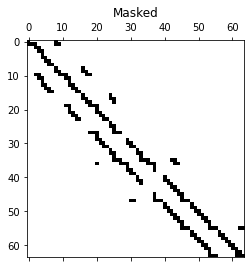

In [169]:
plt.spy(x.data); plt.title('Masked'); plt.show()

In [174]:
# Support measures
x.mask = (x.data<=0)
Masking_sol, Masking_Truth = ones((2,N,N));    Masking_sol[x.mask] = 0;    Masking_Truth[sol<=0] = 0
Masking_sol[Masking_Truth + Masking_sol != 2] = 0        # Cancel common support
print( 'Shared support:   {0:3.0f} \nApproximation:    {1:3.0f} \nExact support:    {2:3.0f} '.format(
    Masking_sol.sum(),x.compressed().size,sol[sol>0].size) )

Shared support:   127 
Approximation:    218 
Exact support:    127 


#### Sanity check using the support of the true solution:

In [25]:
x, y, obj, every_critical, every_iter = primal_dual_improved(c,m,n, 10000, collect_obj = True, true_obj = obj_exact, true_obj_tol = 1e-7, true_solution = sol, save_iter = True, guess_s = sol)


*** Primal Dual with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
*      1 |   1.0e+00 |  8.0e-01  |     0.00 s |   0.8705 |  0.1545
*      3 |   1.0e-01 |  2.0e-02  |     0.00 s |   0.5059 |  0.7856
*     27 |   1.0e-02 |  4.5e-03  |     0.01 s |   0.4080 |  1.0729
*     92 |   1.0e-03 |  9.3e-04  |     0.03 s |   0.2658 |  0.9533
*    288 |   1.0e-04 |  1.8e-05  |     0.06 s |   0.1295 |  0.9894
*   1684 |   1.0e-05 |  3.2e-06  |     0.32 s |   0.0180 |  0.9990
*   2655 |   1.0e-06 |  3.7e-07  |     0.51 s |   0.0178 |  0.9996
*   9748 |   1.0e-07 |  7.9e-08  |     1.82 s |   0.0055 |  1.0000
Solution found with given tolerance.
------------------------------------------------------------------

Algorithm stopped after 1.8187 seconds and 9748 iterations


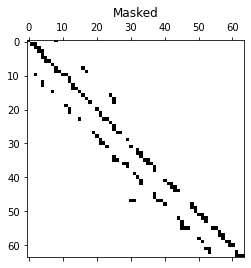

In [26]:
plt.spy(x.data); plt.title('Masked'); plt.show()

In [27]:
# Support measures
Masking_sol, Masking_Truth = ones((2,N,N));    Masking_sol[x.mask] = 0;    Masking_Truth[sol<=0] = 0
Masking_sol[Masking_Truth + Masking_sol != 2] = 0        # Cancel common support
print( 'Shared support:   {0:3.0f} \nApproximation:    {1:3.0f} \nExact support:    {2:3.0f} '.format(
    Masking_sol.sum(),x.compressed().size,sol[sol>0].size) )

Shared support:   127 
Approximation:    127 
Exact support:    127 


**Let us reset the algorithm from the solution we got on our first run:**

In [22]:
xₑ, yₑ, obj, every_critical, every_iter = primal_dual_improved(c,m,n, 100000, collect_obj = True, true_obj = obj_exact, true_obj_tol = 1e-7, true_solution = sol, save_iter = True, guess_s = x, guess_x = x, guess_y = y)


*** Primal Dual with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
*      0 |   1.0e+00 |  1.5e-05  |     0.00 s |   0.3759 |  1.0000
*      1 |   1.0e-01 |  2.9e-05  |     0.00 s |   0.3759 |  1.0000
*      2 |   1.0e-02 |  4.3e-05  |     0.00 s |   0.3759 |  1.0000
*      3 |   1.0e-03 |  5.6e-05  |     0.01 s |   0.3759 |  1.0000
*      4 |   1.0e-04 |  6.9e-05  |     0.01 s |   0.3759 |  1.0000
*     27 |   1.0e-05 |  2.0e-07  |     0.01 s |   0.3759 |  1.0000
*     60 |   1.0e-06 |  5.5e-07  |     0.02 s |   0.3759 |  1.0000
*    547 |   1.0e-07 |  5.1e-08  |     0.12 s |   0.3759 |  1.0000
Solution found with given tolerance.
------------------------------------------------------------------

Algorithm stopped after 0.1206 seconds and 547 iterations


In [23]:
x.count(), xₑ.count()

(220, 217)

In [24]:
# Support measures
xₑ.mask = (xₑ.data<=0)
Masking_sol, Masking_Truth = ones((2,N,N));    Masking_sol[xₑ.mask] = 0;    Masking_Truth[sol<=0] = 0
Masking_sol[Masking_Truth + Masking_sol != 2] = 0        # Cancel common support
print( 'Shared support:   {0:3.0f} \nApproximation:    {1:3.0f} \nExact support:    {2:3.0f} '.format(
    Masking_sol.sum(),xₑ.compressed().size,sol[sol>0].size) )

Shared support:   127 
Approximation:    218 
Exact support:    127 


This hints that maybe we could try some sparsity techniques to refine the support as we increase the tolerance requirements.

- Test without any initial mask:

+++ Size of the support +++

*** Primal Dual with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
*      4 |   1.0e+00 |  5.6e-01  |     0.00 s |   0.8888 |  0.9473
*      6 |   1.0e-01 |  5.9e-02  |     0.01 s |   0.8619 |  0.8521
*    327 |   1.0e-02 |  9.8e-03  |     0.08 s |   0.3478 |  0.9996
Solution found with given tolerance.
------------------------------------------------------------------

Algorithm stopped after 0.0813 seconds and 327 iterations

+++   4096 → 4096


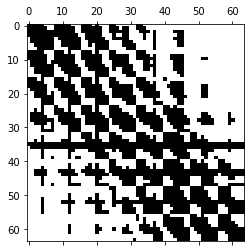


*** Primal Dual with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
*      0 |   1.0e+00 |  9.6e-03  |     0.00 s |   0.3473 |  0.9995
*      1 |   1.0e-01 |  9.6e-03  |     0.00 s |   0.3471 |  0.9996
*      2 |   1.0e-02 |  9.6e-03  |     0.01 s |   0.3469 |  0.9997
*    113 |   1.0e-03 |  9.5e-04  |     0.07 s |   0.3269 |  1.0000
*    282 |   1.0e-04 |  1.2e-05  |     0.13 s |   0.3145 |  1.0002
Solution found with given tolerance.
------------------------------------------------------------------

Algorithm stopped after 0.1305 seconds and 282 iterations

+++   4096 → 1232


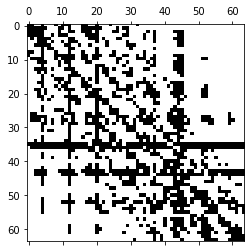


*** Primal Dual with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
*      0 |   1.0e+00 |  1.6e-04  |     0.00 s |   0.3131 |  1.0001
*      1 |   1.0e-01 |  3.2e-04  |     0.00 s |   0.3130 |  1.0001
*      2 |   1.0e-02 |  5.2e-04  |     0.00 s |   0.3130 |  1.0000
*      3 |   1.0e-03 |  7.2e-04  |     0.00 s |   0.3129 |  1.0000
*    124 |   1.0e-04 |  7.8e-05  |     0.03 s |   0.3097 |  0.9998
*    141 |   1.0e-05 |  1.7e-06  |     0.04 s |   0.3096 |  1.0001
------------------------------------------------------------------

Algorithm stopped after 0.1152 seconds and 499 iterations

+++   1232 → 190


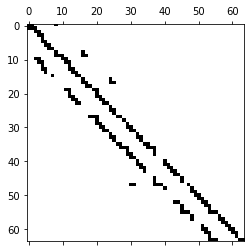


*** Primal Dual with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
*      0 |   1.0e+00 |  1.1e-03  |     0.00 s |   0.3097 |  1.0000
*      1 |   1.0e-01 |  1.0e-03  |     0.00 s |   0.3097 |  1.0000
*      2 |   1.0e-02 |  9.7e-04  |     0.00 s |   0.3097 |  1.0000
*      3 |   1.0e-03 |  8.9e-04  |     0.00 s |   0.3097 |  1.0000
*     11 |   1.0e-04 |  5.4e-05  |     0.00 s |   0.3097 |  1.0000
*    190 |   1.0e-05 |  8.2e-06  |     0.06 s |   0.3097 |  0.9999
*    450 |   1.0e-06 |  7.7e-07  |     0.12 s |   0.3097 |  1.0001
------------------------------------------------------------------

Algorithm stopped after 0.1244 seconds and 499 iterations

+++   190 → 189


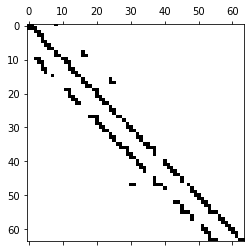

In [28]:
print('+++ Size of the support +++')
x, y, obj, every_critical, every_iter = primal_dual_improved(c,m,n, 500, collect_obj = True, true_obj = obj_exact, true_obj_tol = 1e-2, true_solution = sol, save_iter = True, guess_s = None)
print('\n+++  ',c.size,'→',x.count());    x_sized = x.count()
plt.spy(x.filled()); plt.show()
x, y, obj, every_critical, every_iter = primal_dual_improved(c,m,n, 500, collect_obj = True, true_obj = obj_exact, true_obj_tol = 1e-4, true_solution = sol, save_iter = True, guess_s = x, guess_x = x, guess_y =y)
print('\n+++  ',x_sized,'→',x.count());    x_sized = x.count()
plt.spy(x.filled()); plt.show()
x, y, obj, every_critical, every_iter = primal_dual_improved(c,m,n, 500, collect_obj = True, true_obj = obj_exact, true_obj_tol = 1e-6, true_solution = sol, save_iter = True, guess_s = x, guess_x = x, guess_y =y)
print('\n+++  ',x_sized,'→',x.count());    x_sized = x.count()
plt.spy(x.filled()); plt.show()
x, y, obj, every_critical, every_iter = primal_dual_improved(c,m,n, 500, collect_obj = True, true_obj = obj_exact, true_obj_tol = 1e-7, true_solution = sol, save_iter = True, guess_s = x, guess_x = x, guess_y =y)
print('\n+++  ',x_sized,'→',x.count());    x_sized = x.count()
plt.spy(x.filled()); plt.show()

In [29]:
# Support measures
x.mask = (x.data<=0)
Masking_sol, Masking_Truth = ones((2,N,N));    Masking_sol[x.mask] = 0;    Masking_Truth[sol<=0] = 0
Masking_sol[Masking_Truth + Masking_sol != 2] = 0        # Cancel common support
print( 'Shared support:   {0:3.0f} \nApproximation:    {1:3.0f} \nExact support:    {2:3.0f} '.format(
    Masking_sol.sum(),x.compressed().size,sol[sol>0].size) )

Shared support:   123 
Approximation:    189 
Exact support:    127 


- Test with the initial mask from ER:

+++ Size of the support +++

*** Primal Dual with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
*      1 |   1.0e+00 |  5.8e-01  |     0.01 s |   0.8799 |  0.2558
*      9 |   1.0e-01 |  4.0e-02  |     0.01 s |   0.5692 |  1.0693
*     24 |   1.0e-02 |  9.1e-03  |     0.01 s |   0.5408 |  1.0828
Solution found with given tolerance.
------------------------------------------------------------------

Algorithm stopped after 0.0122 seconds and 24 iterations

+++   4096 → 220


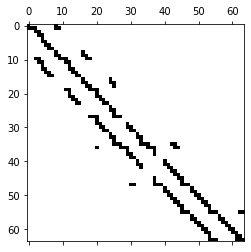


*** Primal Dual with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
*      0 |   1.0e+00 |  2.2e-02  |     0.00 s |   0.5340 |  1.0563
*      1 |   1.0e-01 |  3.5e-02  |     0.00 s |   0.5266 |  1.0465
*     29 |   1.0e-02 |  9.8e-03  |     0.01 s |   0.4460 |  1.0219
*     56 |   1.0e-03 |  3.6e-04  |     0.01 s |   0.3973 |  1.0098
------------------------------------------------------------------

Algorithm stopped after 0.1088 seconds and 499 iterations

+++   220 → 183


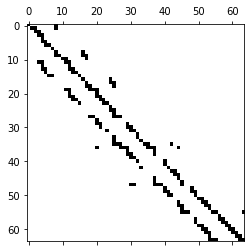


*** Primal Dual with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
*      0 |   1.0e+00 |  1.1e-02  |     0.00 s |   0.3592 |  0.9890
*      1 |   1.0e-01 |  1.1e-02  |     0.00 s |   0.3582 |  0.9906
*     17 |   1.0e-02 |  9.3e-03  |     0.01 s |   0.3547 |  0.9985
*     36 |   1.0e-03 |  1.1e-04  |     0.01 s |   0.3606 |  0.9907
*    236 |   1.0e-04 |  6.7e-05  |     0.05 s |   0.3622 |  0.9958
------------------------------------------------------------------

Algorithm stopped after 0.1195 seconds and 499 iterations

+++   183 → 176


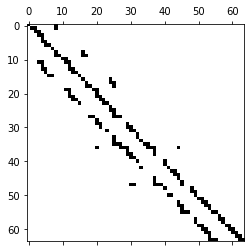


*** Primal Dual with M = 64, N = 64, MN = 4096 ***


Objective from ground truth: 0.016271821448840373 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
*      0 |   1.0e+00 |  2.0e-02  |     0.00 s |   0.3570 |  0.9980
*      1 |   1.0e-01 |  2.2e-02  |     0.00 s |   0.3568 |  0.9980
*     30 |   1.0e-02 |  9.6e-03  |     0.01 s |   0.3624 |  0.9957
*     35 |   1.0e-03 |  5.0e-04  |     0.01 s |   0.3657 |  0.9960
*    135 |   1.0e-04 |  5.3e-05  |     0.03 s |   0.3652 |  0.9948
------------------------------------------------------------------

Algorithm stopped after 0.1159 seconds and 499 iterations

+++   176 → 174


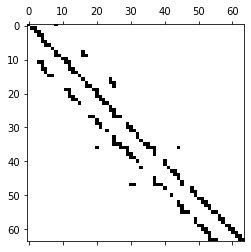

In [30]:
print('+++ Size of the support +++')
x, y, obj, every_critical, every_iter = primal_dual_improved(c,m,n, 500, collect_obj = True, true_obj = obj_exact, true_obj_tol = 1e-2, true_solution = sol, save_iter = True, guess_s = ER)
print('\n+++  ',c.size,'→',x.count());    x_sized = x.count()
plt.spy(x.filled()); plt.show()
x, y, obj, every_critical, every_iter = primal_dual_improved(c,m,n, 500, collect_obj = True, true_obj = obj_exact, true_obj_tol = 1e-4, true_solution = sol, save_iter = True, guess_s = x, guess_x = x, guess_y =y)
print('\n+++  ',x_sized,'→',x.count());    x_sized = x.count()
plt.spy(x.filled()); plt.show()
x, y, obj, every_critical, every_iter = primal_dual_improved(c,m,n, 500, collect_obj = True, true_obj = obj_exact, true_obj_tol = 1e-6, true_solution = sol, save_iter = True, guess_s = x, guess_x = x, guess_y =y)
print('\n+++  ',x_sized,'→',x.count());    x_sized = x.count()
plt.spy(x.filled()); plt.show()
x, y, obj, every_critical, every_iter = primal_dual_improved(c,m,n, 500, collect_obj = True, true_obj = obj_exact, true_obj_tol = 1e-7, true_solution = sol, save_iter = True, guess_s = x, guess_x = x, guess_y =y)
print('\n+++  ',x_sized,'→',x.count());    x_sized = x.count()
plt.spy(x.filled()); plt.show()

In [31]:
# Support measures
x.mask = (x.data<=0)
Masking_sol, Masking_Truth = ones((2,N,N));    Masking_sol[x.mask] = 0;    Masking_Truth[sol<=0] = 0
Masking_sol[Masking_Truth + Masking_sol != 2] = 0        # Cancel common support
print( 'Shared support:   {0:3.0f} \nApproximation:    {1:3.0f} \nExact support:    {2:3.0f} '.format(
    Masking_sol.sum(),x.compressed().size,sol[sol>0].size) )

Shared support:   119 
Approximation:    175 
Exact support:    127 


### Results for $32\times 32$

Sparsity plots:

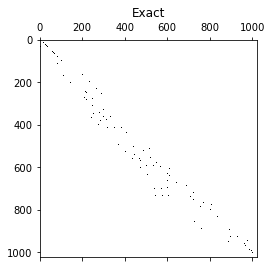

In [10]:
plt.spy(sol); plt.title('Exact'); plt.show()

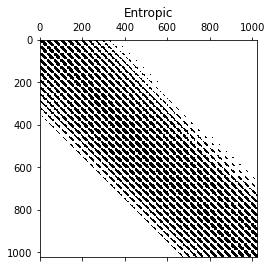

In [11]:
plt.spy(ER); plt.title('Entropic'); plt.show()

**Run without a guess:**

In [12]:
#x, obj, every_critical, every_iter = primal_dual_improved(c,m,n, 100000, collect_obj = True, true_obj = obj_exact, true_obj_tol = 1e-7, true_solution = sol, save_iter = True, guess = None)
x, y, obj, every_critical, every_iter = primal_dual_improved(c,m,n, 10000, collect_obj = True, true_obj = obj_exact, true_obj_tol = 1e-7, true_solution = sol, save_iter = True, guess_s = None)


*** Primal Dual with M = 1024, N = 1024, MN = 1048576 ***


Objective from ground truth: 0.010675024052995653 

     It  | Tolerance |  obj dist |    Time    |  ‖x‖_F  |  ‖x‖_1  
-----------------------------------------------------------------
*      1 |   1.0e+00 |  1.0e+00  |     0.09 s |  0.9982 |  0.0172
*    759 |   1.0e-01 |  1.0e-01  |    30.59 s |  0.6419 |  1.0023
*   1249 |   1.0e-02 |  9.9e-03  |    53.17 s |  0.4339 |  1.0010
*   1341 |   1.0e-03 |  9.4e-04  |    57.16 s |  0.4200 |  1.0001
*   1353 |   1.0e-04 |  5.6e-05  |    57.72 s |  0.4188 |  0.9996
*   3689 |   1.0e-05 |  4.8e-06  |   161.00 s |  0.3876 |  1.0001
*   4528 |   1.0e-06 |  3.5e-07  |   199.81 s |  0.3874 |  1.0001
*   4852 |   1.0e-07 |  4.3e-08  |   215.24 s |  0.3874 |  0.9999
Solution found with given tolerance.
-----------------------------------------------------------------

Algorithm stopped after 215.2431 seconds and 4852 iterations


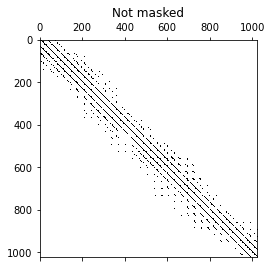

In [13]:
plt.spy(x); plt.title('Not masked'); plt.show()

In [14]:
# Support measures
x.mask = (x.data<=0)
Masking_sol, Masking_Truth = ones((2,N,N));    Masking_sol[x.mask] = 0;    Masking_Truth[sol<=0] = 0
Masking_sol[Masking_Truth + Masking_sol != 2] = 0        # Cancel common support
print( 'Shared support:   {0:3.0f} \nApproximation:    {1:3.0f} \nExact support:    {2:3.0f} '.format(
    Masking_sol.sum(),x.compressed().size,sol[sol>0].size) )

Shared support:   2040 
Approximation:    14069 
Exact support:    2047 


**Include initial guess from ER:**

In [15]:
x, y, obj, every_critical, every_iter = primal_dual_improved(c,m,n, 10000, collect_obj = True, true_obj = obj_exact, true_obj_tol = 1e-7, true_solution = sol, save_iter = True, guess_s = ER)


*** Primal Dual with M = 1024, N = 1024, MN = 1048576 ***


Objective from ground truth: 0.010675024052995653 

     It  | Tolerance |  obj dist |    Time    |  ‖x‖_F  |  ‖x‖_1  
-----------------------------------------------------------------
*      1 |   1.0e+00 |  1.0e+00  |     0.09 s |  0.9982 |  0.0168
*    764 |   1.0e-01 |  1.0e-01  |    28.85 s |  0.6458 |  1.0027
*   1253 |   1.0e-02 |  1.0e-02  |    47.07 s |  0.4354 |  1.0010
*   1355 |   1.0e-03 |  8.4e-04  |    50.87 s |  0.4200 |  0.9993
*   1359 |   1.0e-04 |  9.2e-05  |    51.02 s |  0.4196 |  0.9995
*   3652 |   1.0e-05 |  3.8e-06  |   134.49 s |  0.3881 |  0.9999
*   3663 |   1.0e-06 |  9.7e-07  |   134.85 s |  0.3881 |  1.0001
*   3664 |   1.0e-07 |  2.5e-08  |   134.87 s |  0.3881 |  1.0001
Solution found with given tolerance.
-----------------------------------------------------------------

Algorithm stopped after 134.8749 seconds and 3664 iterations


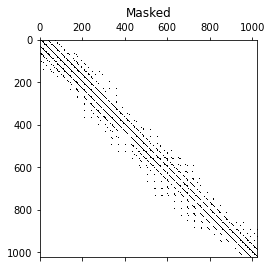

In [16]:
plt.spy(x.filled()); plt.title('Masked'); plt.show()

In [17]:
# Support measures
x.mask = (x.data<=0)
Masking_sol, Masking_Truth = ones((2,N,N));    Masking_sol[x.mask] = 0;    Masking_Truth[sol<=0] = 0
Masking_sol[Masking_Truth + Masking_sol != 2] = 0        # Cancel common support
print( 'Shared support:   {0:3.0f} \nApproximation:    {1:3.0f} \nExact support:    {2:3.0f} '.format(
    Masking_sol.sum(),x.compressed().size,sol[sol>0].size) )

Shared support:   2043 
Approximation:    12367 
Exact support:    2047 


#### Sanity check using the support of the true solution:

In [22]:
x, y, obj, every_critical, every_iter = primal_dual_improved(c,m,n, 10000, collect_obj = True, true_obj = obj_exact, true_obj_tol = 1e-7, true_solution = sol, save_iter = True, guess_s = sol)


*** Primal Dual with M = 1024, N = 1024, MN = 1048576 ***


Objective from ground truth: 0.010675024052995653 

     It  | Tolerance |  obj dist |    Time    |  ‖x‖_F  |  ‖x‖_1  
-----------------------------------------------------------------
*      1 |   1.0e+00 |  1.0e+00  |     0.04 s |  0.9981 |  0.0017
*     20 |   1.0e-01 |  9.6e-02  |     0.45 s |  0.6379 |  1.1447
*     80 |   1.0e-02 |  2.5e-03  |     1.72 s |  0.5260 |  0.9957
*    130 |   1.0e-03 |  7.3e-04  |     2.75 s |  0.4431 |  1.0652
*    278 |   1.0e-04 |  8.3e-05  |     5.92 s |  0.3480 |  1.0201
*   1990 |   1.0e-05 |  4.8e-07  |    42.92 s |  0.1680 |  0.9917
*   7681 |   1.0e-06 |  9.5e-07  |   167.33 s |  0.0903 |  0.9998
-----------------------------------------------------------------

Algorithm stopped after 218.3641 seconds and 9999 iterations


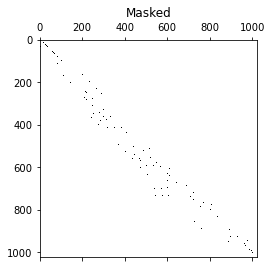

In [23]:
plt.spy(x.filled()); plt.title('Masked'); plt.show()

In [24]:
# Support measures
x.mask = (x.data<=0)
Masking_sol, Masking_Truth = ones((2,N,N));    Masking_sol[x.mask] = 0;    Masking_Truth[sol<=0] = 0
Masking_sol[Masking_Truth + Masking_sol != 2] = 0        # Cancel common support
print( 'Shared support:   {0:3.0f} \nApproximation:    {1:3.0f} \nExact support:    {2:3.0f} '.format(
    Masking_sol.sum(),x.compressed().size,sol[sol>0].size) )

Shared support:   2034 
Approximation:    2034 
Exact support:    2047 


**Let us reset the algorithm from the solution we got on our first run:**

In [18]:
xₑ, yₑ, obj, every_critical, every_iter = primal_dual_improved(c,m,n, 100000, collect_obj = True, true_obj = obj_exact, true_obj_tol = 1e-8, true_solution = sol, save_iter = True, guess_s = x, guess_x = x, guess_y = y)


*** Primal Dual with M = 1024, N = 1024, MN = 1048576 ***


Objective from ground truth: 0.010675024052995653 

     It  | Tolerance |  obj dist |    Time    |  ‖x‖_F  |  ‖x‖_1  
-----------------------------------------------------------------
*      0 |   1.0e+00 |  1.2e-06  |     0.05 s |  0.3881 |  1.0001
*      1 |   1.0e-01 |  2.8e-06  |     0.07 s |  0.3881 |  1.0001
*      2 |   1.0e-02 |  2.0e-06  |     0.10 s |  0.3881 |  1.0001
*      3 |   1.0e-03 |  2.1e-06  |     0.12 s |  0.3881 |  1.0001
*      4 |   1.0e-04 |  6.3e-07  |     0.14 s |  0.3881 |  1.0000
*      5 |   1.0e-05 |  2.3e-07  |     0.16 s |  0.3881 |  1.0000
*     11 |   1.0e-06 |  1.1e-08  |     0.30 s |  0.3881 |  1.0000
*   5922 |   1.0e-07 |  6.4e-08  |   125.71 s |  0.3878 |  1.0000
*   8626 |   1.0e-08 |  4.9e-09  |   183.35 s |  0.3878 |  1.0000
Solution found with given tolerance.
-----------------------------------------------------------------

Algorithm stopped after 183.3468 seconds and 8626 iterat

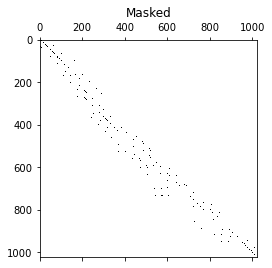

In [19]:
plt.spy(xₑ.filled()); plt.title('Masked'); plt.show()

In [20]:
# Support measures
xₑ.mask = (xₑ.data<=0)
Masking_sol, Masking_Truth = ones((2,N,N));    Masking_sol[xₑ.mask] = 0;    Masking_Truth[sol<=0] = 0
Masking_sol[Masking_Truth + Masking_sol != 2] = 0        # Cancel common support
print( 'Shared support:   {0:3.0f} \nApproximation:    {1:3.0f} \nExact support:    {2:3.0f} '.format(
    Masking_sol.sum(),xₑ.compressed().size,sol[sol>0].size) )

Shared support:   2042 
Approximation:    12357 
Exact support:    2047 


In [21]:
sol[sol>0].size, xₑ.compressed().size

(2047, 12357)

This hints that maybe we could try some sparsity techniques to refine the support as we increase the tolerance requirements.

+++ Size of the support +++

*** Primal Dual with M = 1024, N = 1024, MN = 1048576 ***


Objective from ground truth: 0.010675024052995653 

     It  | Tolerance |  obj dist |    Time    |  ‖x‖_F  |  ‖x‖_1  
-----------------------------------------------------------------
*      1 |   1.0e+00 |  1.0e+00  |     0.05 s |  0.9982 |  0.0168
*    764 |   1.0e-01 |  1.0e-01  |    19.17 s |  0.6458 |  1.0027
*   1253 |   1.0e-02 |  1.0e-02  |    31.41 s |  0.4354 |  1.0010
Solution found with given tolerance.
-----------------------------------------------------------------

Algorithm stopped after 31.4101 seconds and 1253 iterations

+++   1048576 → 54262


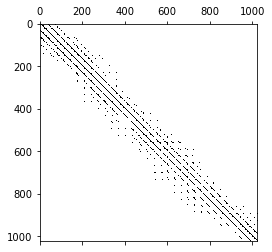


*** Primal Dual with M = 1024, N = 1024, MN = 1048576 ***


Objective from ground truth: 0.010675024052995653 

     It  | Tolerance |  obj dist |    Time    |  ‖x‖_F  |  ‖x‖_1  
-----------------------------------------------------------------
*      0 |   1.0e+00 |  9.9e-03  |     0.02 s |  0.4326 |  1.0010
*      1 |   1.0e-01 |  9.8e-03  |     0.04 s |  0.4324 |  1.0010
*      2 |   1.0e-02 |  9.8e-03  |     0.06 s |  0.4322 |  1.0010
*    101 |   1.0e-03 |  8.8e-04  |     2.26 s |  0.4174 |  0.9995
*    107 |   1.0e-04 |  4.7e-05  |     2.40 s |  0.4167 |  0.9997
Solution found with given tolerance.
-----------------------------------------------------------------

Algorithm stopped after 2.3950 seconds and 107 iterations

+++   54262 → 4900


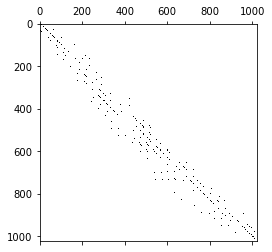


*** Primal Dual with M = 1024, N = 1024, MN = 1048576 ***


Objective from ground truth: 0.010675024052995653 

     It  | Tolerance |  obj dist |    Time    |  ‖x‖_F  |  ‖x‖_1  
-----------------------------------------------------------------
*      0 |   1.0e+00 |  5.9e-05  |     0.02 s |  0.4140 |  0.9997
*      1 |   1.0e-01 |  1.6e-04  |     0.04 s |  0.4139 |  0.9998
*      2 |   1.0e-02 |  2.6e-04  |     0.05 s |  0.4138 |  0.9998
*      3 |   1.0e-03 |  3.5e-04  |     0.08 s |  0.4136 |  0.9998
*   1541 |   1.0e-04 |  8.0e-05  |    34.17 s |  0.3859 |  1.0001
*   1543 |   1.0e-05 |  9.2e-06  |    34.22 s |  0.3859 |  1.0000
-----------------------------------------------------------------

Algorithm stopped after 43.5906 seconds and 1999 iterations

+++   4900 → 4363


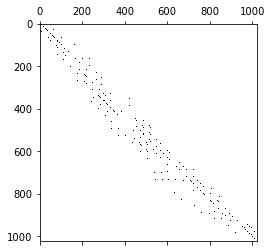


*** Primal Dual with M = 1024, N = 1024, MN = 1048576 ***


Objective from ground truth: 0.010675024052995653 

     It  | Tolerance |  obj dist |    Time    |  ‖x‖_F  |  ‖x‖_1  
-----------------------------------------------------------------
*      0 |   1.0e+00 |  1.4e-03  |     0.03 s |  0.3854 |  1.0000
*      1 |   1.0e-01 |  1.4e-03  |     0.05 s |  0.3854 |  1.0000
*      2 |   1.0e-02 |  1.5e-03  |     0.07 s |  0.3854 |  1.0000
*    112 |   1.0e-03 |  9.7e-04  |     2.35 s |  0.3853 |  1.0001
*    534 |   1.0e-04 |  7.1e-05  |    11.64 s |  0.3849 |  1.0001
*    536 |   1.0e-05 |  6.7e-06  |    11.69 s |  0.3849 |  1.0002
-----------------------------------------------------------------

Algorithm stopped after 42.5723 seconds and 1999 iterations

+++   4363 → 3101


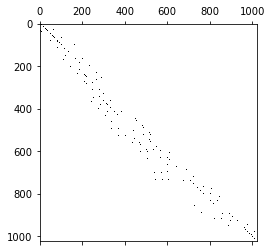


*** Primal Dual with M = 1024, N = 1024, MN = 1048576 ***


Objective from ground truth: 0.010675024052995653 

     It  | Tolerance |  obj dist |    Time    |  ‖x‖_F  |  ‖x‖_1  
-----------------------------------------------------------------
*      0 |   1.0e+00 |  5.7e-04  |     0.02 s |  0.3849 |  1.0001
*      1 |   1.0e-01 |  5.6e-04  |     0.04 s |  0.3849 |  1.0001
*      2 |   1.0e-02 |  5.6e-04  |     0.06 s |  0.3849 |  1.0001
*      3 |   1.0e-03 |  5.6e-04  |     0.08 s |  0.3849 |  1.0001
*   1293 |   1.0e-04 |  9.9e-05  |    27.79 s |  0.3849 |  1.0001
*   1297 |   1.0e-05 |  8.3e-06  |    27.86 s |  0.3849 |  1.0001
-----------------------------------------------------------------

Algorithm stopped after 43.0299 seconds and 1999 iterations

+++   3101 → 3074


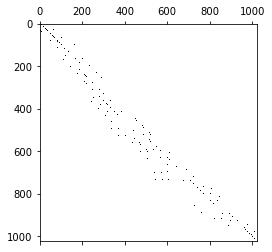

In [25]:
print('+++ Size of the support +++')
x, y, obj, every_critical, every_iter = primal_dual_improved(c,m,n, 2000, collect_obj = True, true_obj = obj_exact, true_obj_tol = 1e-2, true_solution = sol, save_iter = True, guess_s = ER)
print('\n+++  ',c.size,'→',x.count());    x_sized = x.count()
plt.spy(x.filled()); plt.show()
x, y, obj, every_critical, every_iter = primal_dual_improved(c,m,n, 2000, collect_obj = True, true_obj = obj_exact, true_obj_tol = 1e-4, true_solution = sol, save_iter = True, guess_s = x, guess_x = x, guess_y =y)
print('\n+++  ',x_sized,'→',x.count());    x_sized = x.count()
plt.spy(x.filled()); plt.show()
x, y, obj, every_critical, every_iter = primal_dual_improved(c,m,n, 2000, collect_obj = True, true_obj = obj_exact, true_obj_tol = 1e-6, true_solution = sol, save_iter = True, guess_s = x, guess_x = x, guess_y =y)
print('\n+++  ',x_sized,'→',x.count());    x_sized = x.count()
plt.spy(x.filled()); plt.show()
x, y, obj, every_critical, every_iter = primal_dual_improved(c,m,n, 2000, collect_obj = True, true_obj = obj_exact, true_obj_tol = 1e-7, true_solution = sol, save_iter = True, guess_s = x, guess_x = x, guess_y =y)
print('\n+++  ',x_sized,'→',x.count());    x_sized = x.count()
plt.spy(x.filled()); plt.show()
x, y, obj, every_critical, every_iter = primal_dual_improved(c,m,n, 2000, collect_obj = True, true_obj = obj_exact, true_obj_tol = 1e-7, true_solution = sol, save_iter = True, guess_s = x, guess_x = x, guess_y =y)
print('\n+++  ',x_sized,'→',x.count());    x_sized = x.count()
plt.spy(x.filled()); plt.show()

In [26]:
# Support measures
x.mask = (x.data<=0)
Masking_sol, Masking_Truth = ones((2,N,N));    Masking_sol[x.mask] = 0;    Masking_Truth[sol<=0] = 0
Masking_sol[Masking_Truth + Masking_sol != 2] = 0        # Cancel common support
print( 'Shared support:   {0:3.0f} \nApproximation:    {1:3.0f} \nExact support:    {2:3.0f} '.format(
    Masking_sol.sum(),x.compressed().size,sol[sol>0].size) )

Shared support:   1967 
Approximation:    11977 
Exact support:    2047 


## Visualise and store results

In [17]:
main_folder = folder + '_Results'
out_folder  = main_folder + '/' + instance
algorithm   = 'PD_Improved-'

In [18]:
# Check if main folder for results exists, else create it
if not os.path.exists(main_folder):    os.makedirs(main_folder)
# Now create a folder for the results of the instance
if not os.path.exists(out_folder):    os.makedirs(out_folder)
out_folder += '/' + algorithm

### Spies & Heat maps

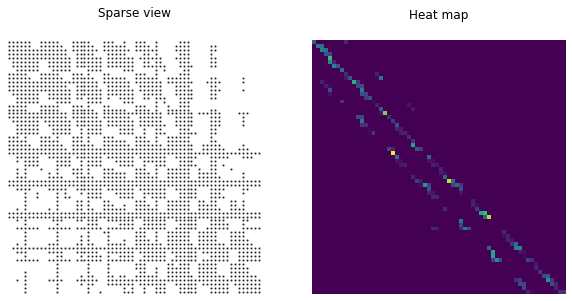

In [19]:
# Visualise solution
plt.figure(figsize = (10,5))

plt.subplot(1, 2, 1)
plt.spy(x, markersize=1, aspect = 1, markeredgecolor = 'black', alpha=0.75);    plt.axis('off')
plt.title('Sparse view')
plt.subplot(1, 2, 2)
plt.imshow(x);    plt.axis('off');    plt.title('Heat map\n')

plt.savefig(out_folder+'Sparse-Heat.pdf', bbox_inches='tight',transparent=True)
plt.show()

Solution with initial guess:

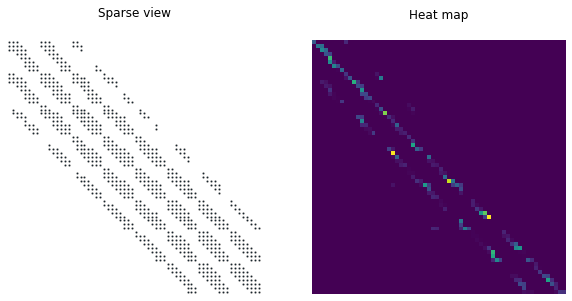

In [31]:
# Visualise solution
plt.figure(figsize = (10,5))

plt.subplot(1, 2, 1)
plt.spy(x, markersize=1, aspect = 1, markeredgecolor = 'black', alpha=0.75);    plt.axis('off')
plt.title('Sparse view')
plt.subplot(1, 2, 2)
plt.imshow(x);    plt.axis('off');    plt.title('Heat map\n')

#plt.savefig(out_folder+'Sparse-Heat.pdf', bbox_inches='tight',transparent=True)
plt.show()

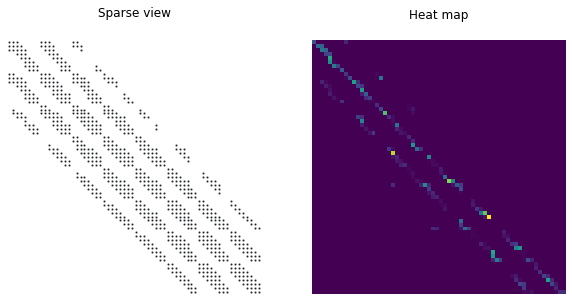

In [82]:
# Visualise solution
plt.figure(figsize = (10,5))

plt.subplot(1, 2, 1)
plt.spy(x, markersize=1, aspect = 1, markeredgecolor = 'black', alpha=0.75);    plt.axis('off')
plt.title('Sparse view')
plt.subplot(1, 2, 2)
plt.imshow(x);    plt.axis('off');    plt.title('Heat map\n')

#plt.savefig(out_folder+'Sparse-Heat.pdf', bbox_inches='tight',transparent=True)
plt.show()

### Evolution across iterations

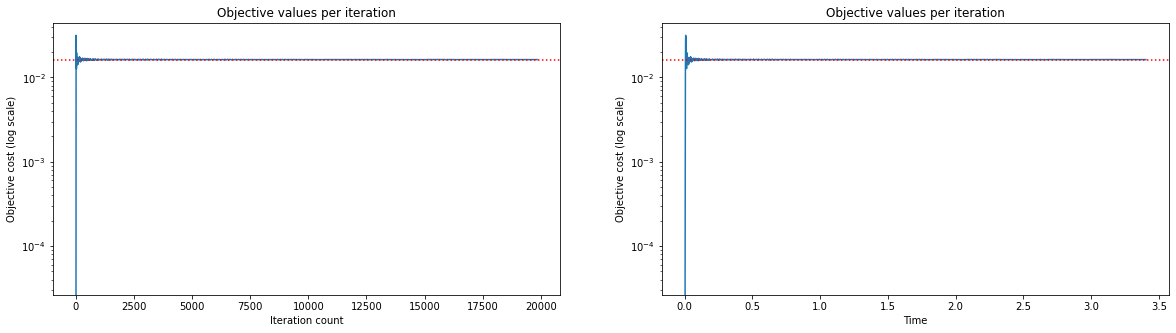

In [152]:
# Visualise evolution of objective values
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(obj)
plt.axhline(y=obj_exact, color='r', linestyle=':')
plt.yscale('log');    plt.title('Objective values per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Objective cost (log scale)')
plt.subplot(1, 2, 2)
plt.plot(np.append([0], every_iter['time']),obj)
plt.axhline(y=obj_exact, color='r', linestyle=':')
plt.yscale('log')
plt.title('Objective values per iteration')
plt.xlabel('Time');    plt.ylabel('Objective cost (log scale)')

#plt.savefig(out_folder+'Objective.pdf', bbox_inches='tight',transparent=True)
plt.show()

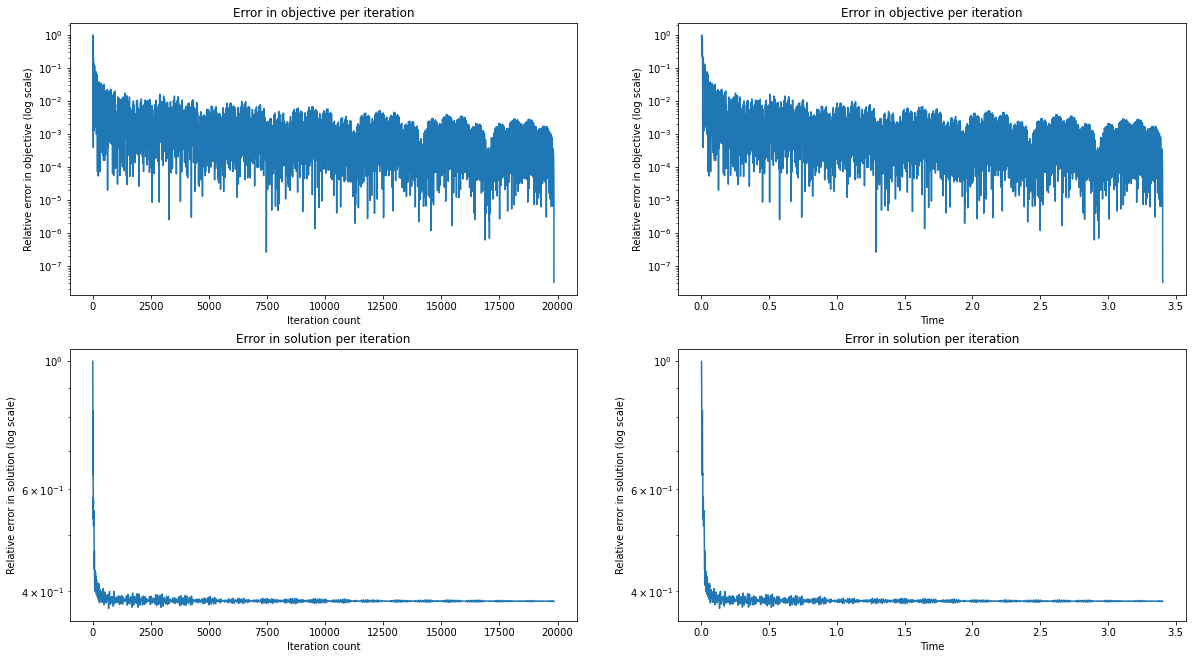

In [153]:
# Visualise evolution of relative errors
plt.figure(figsize = (20,11))

plt.subplot(2, 2, 1)
plt.plot(every_iter['dist_obj'])
plt.yscale('log')
plt.title('Error in objective per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Relative error in objective (log scale)')
plt.subplot(2, 2, 2)
plt.plot(every_iter['time'],every_iter['dist_obj'])
plt.yscale('log')
plt.title('Error in objective per iteration')
plt.xlabel('Time');    plt.ylabel('Relative error in objective (log scale)')
plt.subplot(2, 2, 3)
plt.plot(every_iter['dist_x'])
plt.yscale('log')
plt.title('Error in solution per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Relative error in solution (log scale)')
plt.subplot(2, 2, 4)
plt.plot(every_iter['time'],every_iter['dist_x'])
plt.yscale('log')
plt.title('Error in solution per iteration')
plt.xlabel('Time');    plt.ylabel('Relative error in solution (log scale)')

#plt.savefig(out_folder+'Rel_Error.pdf', bbox_inches='tight',transparent=True)
plt.show()

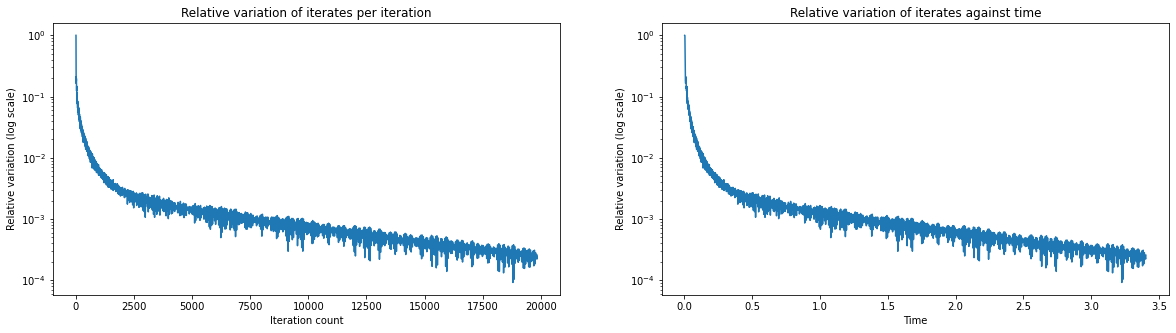

In [154]:
# Relative variation
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(every_iter['it'], every_iter['rel_var'])
plt.yscale('log')
plt.xlabel('Iteration count');    plt.ylabel('Relative variation (log scale)');
plt.title('Relative variation of iterates per iteration')

plt.subplot(1, 2, 2)
plt.plot(every_iter['time'], every_iter['rel_var'])
plt.yscale('log')
plt.xlabel('Time');    plt.ylabel('Relative variation (log scale)');
plt.title('Relative variation of iterates against time')

#plt.savefig(out_folder+'Relative_Var.pdf', bbox_inches='tight',transparent=True)
plt.show()

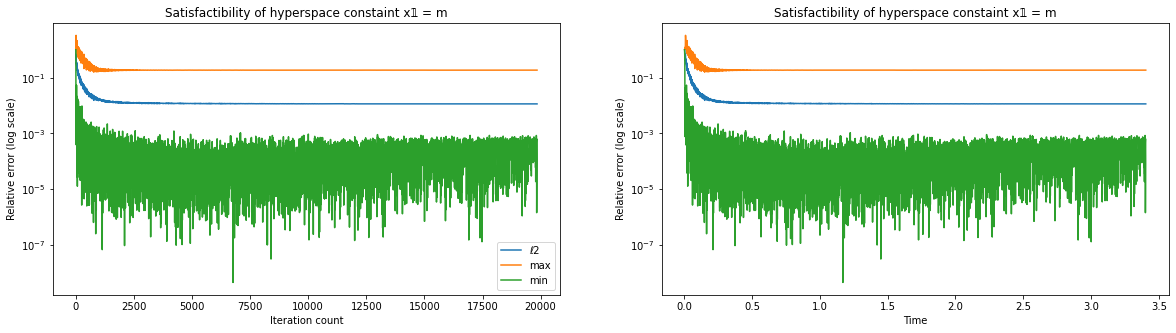

In [155]:
# Relative variation for x𝟙 = m
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(every_iter['it'], every_iter['hyperₘ']['L2'], label='ℓ2')
plt.plot(every_iter['it'], every_iter['hyperₘ']['max'], label='max')
plt.plot(every_iter['it'], every_iter['hyperₘ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Iteration count');    plt.ylabel('Relative error (log scale)');
plt.title('Satisfactibility of hyperspace constaint x𝟙 = m')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(every_iter['time'], every_iter['hyperₘ']['L2'], label='ℓ2')
plt.plot(every_iter['time'], every_iter['hyperₘ']['max'], label='max')
plt.plot(every_iter['time'], every_iter['hyperₘ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Time');    plt.ylabel('Relative error (log scale)');
plt.title('Satisfactibility of hyperspace constaint x𝟙 = m')

#plt.savefig(out_folder+'RelE_m.pdf', bbox_inches='tight',transparent=True)
plt.show()

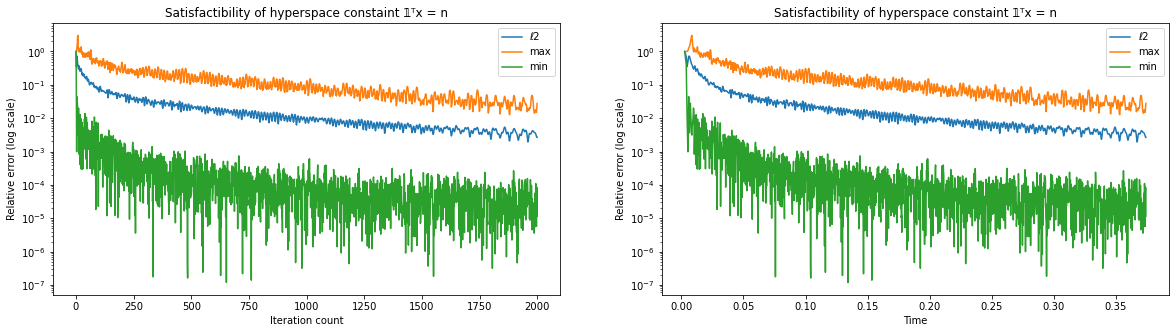

In [391]:
# Relative variation for 𝟙ᵀx = n
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(every_iter['it'], every_iter['hyperₙ']['L2'], label='ℓ2')
plt.plot(every_iter['it'], every_iter['hyperₙ']['max'], label='max')
plt.plot(every_iter['it'], every_iter['hyperₙ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Iteration count');    plt.ylabel('Relative error (log scale)');
plt.title('Satisfactibility of hyperspace constaint 𝟙ᵀx = n');    plt.legend()

plt.subplot(1, 2, 2)
plt.plot(every_iter['time'], every_iter['hyperₙ']['L2'], label='ℓ2')
plt.plot(every_iter['time'], every_iter['hyperₙ']['max'], label='max')
plt.plot(every_iter['time'], every_iter['hyperₙ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Time');    plt.ylabel('Relative error (log scale)');
plt.title('Satisfactibility of hyperspace constaint 𝟙ᵀx = n');    plt.legend()

#plt.savefig(out_folder+'RelE_n.pdf', bbox_inches='tight',transparent=True)
plt.show()

### Export as dataframes

All the data from the above two plots is also available as dataframes:

In [27]:
df_critical = pd.DataFrame.from_dict(every_critical)
df_critical.to_pickle(out_folder+'Critical.pkl') # To read back use pd.read_pickle(file_name)
df_critical.to_excel(out_folder+'Critical.xlsx')
display(df_critical)

# If we want this table in LaTeX format run:
print(df_critical.to_latex(index=False))

,it,obj,tol,dist_obj,time,dist_x
0,20,0.004110,1.000000e+00,7.473931e-01,0.022442,0.817720
1,26,0.016258,1.000000e-01,8.445832e-04,0.028266,0.794347
2,750,0.016434,1.000000e-02,9.973055e-03,0.206107,0.334176
3,1071,0.016287,1.000000e-03,9.488914e-04,0.274810,0.316428
4,1080,0.016273,1.000000e-04,9.637775e-05,0.277153,0.316028
5,1081,0.016272,1.000000e-05,8.254818e-07,0.277492,0.315986
6,1833,0.016272,1.000000e-06,8.186380e-07,0.435859,0.312720
7,8140,0.016272,1.000000e-07,5.025872e-08,1.767318,0.312720


\begin{tabular}{rrrrrr}
\toprule
  it &      obj &          tol &     dist\_obj &     time &   dist\_x \\
\midrule
  20 & 0.004110 & 1.000000e+00 & 7.473931e-01 & 0.022442 & 0.817720 \\
  26 & 0.016258 & 1.000000e-01 & 8.445832e-04 & 0.028266 & 0.794347 \\
 750 & 0.016434 & 1.000000e-02 & 9.973055e-03 & 0.206107 & 0.334176 \\
1071 & 0.016287 & 1.000000e-03 & 9.488914e-04 & 0.274810 & 0.316428 \\
1080 & 0.016273 & 1.000000e-04 & 9.637775e-05 & 0.277153 & 0.316028 \\
1081 & 0.016272 & 1.000000e-05 & 8.254818e-07 & 0.277492 & 0.315986 \\
1833 & 0.016272 & 1.000000e-06 & 8.186380e-07 & 0.435859 & 0.312720 \\
8140 & 0.016272 & 1.000000e-07 & 5.025872e-08 & 1.767318 & 0.312720 \\
\bottomrule
\end{tabular}



In [28]:
#df_every = pd.DataFrame.from_dict(every_iter)
df_every = pd.concat([
                pd.DataFrame.from_dict( {a:b for a,b in every_iter.items() if a not in ['hyperₘ', 'hyperₙ'] } ),
                pd.DataFrame.from_dict( {'hyperₘ-'+a:b for a,b in every_iter['hyperₘ'].items()} ), 
                pd.DataFrame.from_dict( {'hyperₙ-'+a:b for a,b in every_iter['hyperₙ'].items()} )], axis = 1)
df_every.to_pickle(out_folder+'Every.pkl') # To read back use pd.read_pickle(file_name)
df_every.to_excel(out_folder+'Every.xlsx')
display(df_every.head())

,it,obj,dist_obj,time,dist_x,rel_var,hyperₘ-L2,hyperₘ-max,hyperₘ-min,hyperₙ-L2,hyperₙ-max,hyperₙ-min
0,0,0.000000,1.000000,0.002334,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1,0.429072,25.369015,0.005888,0.995409,1.000000,1.369699,2.036308,0.086689,1.384806,1.797270,0.029731
2,2,-0.122430,8.524029,0.006889,0.979066,1.993502,1.351193,2.624691,0.019698,1.221135,1.815521,0.016050
3,3,0.315424,18.384654,0.007590,0.955147,1.102713,1.272243,2.449062,0.175094,1.032333,1.775681,0.144847
4,4,-0.105567,7.487717,0.008280,0.933202,1.547589,1.047288,2.180295,0.005290,0.730081,1.312823,0.002928


In [29]:
df_every.describe()

,it,obj,dist_obj,time,dist_x,rel_var,hyperₘ-L2,hyperₘ-max,hyperₘ-min,hyperₙ-L2,hyperₙ-max,hyperₙ-min
count,8141.000000,8141.000000,8.141000e+03,8141.000000,8141.000000,8140.000000,8141.000000,8141.000000,8.141000e+03,8141.000000,8141.000000,8.141000e+03
mean,4070.000000,0.016630,3.266865e-02,0.906891,0.326913,0.002196,0.002282,0.007532,2.244248e-04,0.001933,0.005606,2.315200e-04
std,2350.248604,0.007751,4.757392e-01,0.495822,0.059895,0.042102,0.039335,0.074004,1.148938e-02,0.033217,0.051377,1.143053e-02
min,0.000000,-0.122430,5.025872e-08,0.002334,0.312720,0.000002,0.000005,0.000045,1.796353e-11,0.000006,0.000057,2.170873e-11
25%,2035.000000,0.016268,1.458758e-04,0.478909,0.312720,0.000029,0.000062,0.000876,5.813902e-07,0.000061,0.000467,5.942042e-07
50%,4070.000000,0.016273,2.904957e-04,0.908676,0.312721,0.000043,0.000090,0.001448,1.573898e-06,0.000087,0.000726,1.753926e-06
75%,6105.000000,0.016278,5.209601e-04,1.334624,0.312721,0.000077,0.000151,0.002440,3.634236e-06,0.000167,0.001495,4.342418e-06
max,8140.000000,0.429072,2.536901e+01,1.767318,1.000000,1.993502,1.369699,2.624691,1.000000e+00,1.384806,1.815521,1.000000e+00


In [30]:
# Finally, store the latest solution:
np.save(out_folder + '_Sol.npy' , x)            # To read back just run:   np.load(outfile)

---
Code used to do performance tests in each piece of code:
```Python
start = time.time()
# ...
end = time.time()
print(end-start)

%timeit -r 10 -n 200 `function(x)`
```

Not much of a speedup for interpolation:
```Python
@jit(nopython=True, fastmath = True)
def interp(xₖ,x, yₖ,y, ρ):
    return ρ*xₖ + (1 - ρ)*x, ρ*yₖ + (1 - ρ)*y

xₖ, yₖ, x, y = ones((4,M,N)); ρ = 1.9
interp(xₖ,x, yₖ,y, ρ); # Run it once
```

---